In [1]:
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

In [2]:
def filtrar_fechas(ventana, start_date, end_date):
    inicio_mes = int(ventana["inicio"].split("-")[0])
    fin_mes = int(ventana["fin"].split("-")[0])

    fechas_rango = pd.date_range(start=start_date, end=end_date)

    if inicio_mes <= fin_mes:
        fechas_filtradas = fechas_rango[fechas_rango.month.isin(range(inicio_mes, fin_mes + 1))]
    else:
        meses_temporada = list(range(inicio_mes, 13)) + list(range(1, fin_mes + 1))
        fechas_filtradas = fechas_rango[fechas_rango.month.isin(meses_temporada)]

    return fechas_filtradas


In [3]:

file_path_desembarques = '../../data/imarpe/processed/fishing_imarpe_industrial_daily_2002_2024_clean.csv'
df_produccion = pd.read_csv(file_path_desembarques, index_col=False)

In [4]:
df_produccion['date'] = pd.to_datetime(df_produccion['FechaReporte'])
df_temp = df_produccion[['ANCHOVETA', 'Puerto', 'date']]
df_temp_grouped = df_temp.groupby(['Puerto', 'date'], as_index=False)['ANCHOVETA'].sum()
df_temp_grouped = df_temp_grouped.rename(columns={'ANCHOVETA': 'tons'})


In [5]:
df_pivot = df_temp_grouped.pivot(index='date', columns='Puerto', values='tons')


In [6]:
specific_ports = [ 
    'Paita', 'Parachique', 
    'Chicama',
    'Salaverry',
    'Chimbote',  
    'Samanco', 'Casma', 'Huarmey', 'Supe',
    'Vegueta',  
    'Huacho','Chancay', 'Callao', 
    'Tambo de Mora',
    'Atico', 'Planchada', 
    'Quilca', 
    'Mollendo', 'Ilo'
]

<Axes: title={'center': 'Number of non-zero values for each port'}, xlabel='Puerto'>

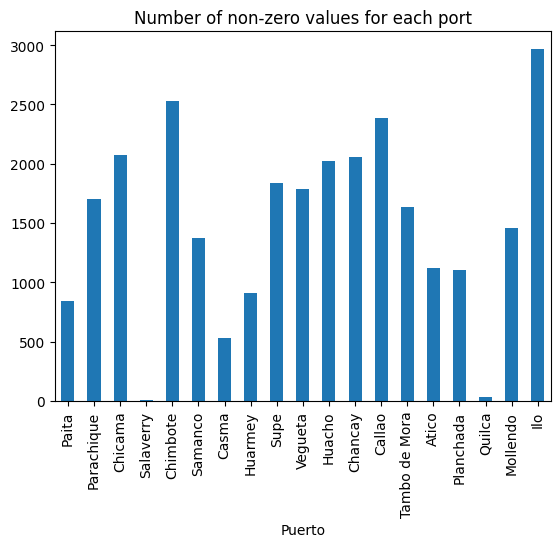

In [7]:

df_pivot[df_pivot>0][specific_ports].count().plot(kind='bar', title='Number of non-zero values for each port')


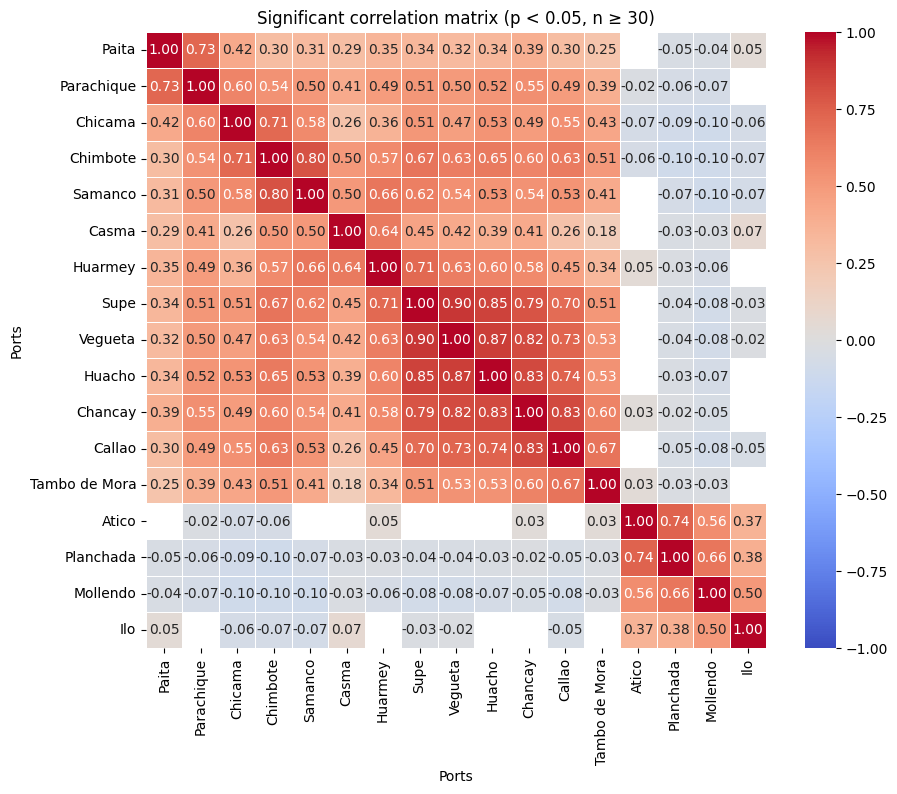

In [8]:
specific_ports_to_drop = ['Salaverry', 'Quilca']

specific_ports_to_keep = [port for port in specific_ports if port not in specific_ports_to_drop]

df_filtered = df_pivot[specific_ports_to_keep].dropna(how='all', axis=1).dropna(how='all', axis=0)

correlation_matrix = df_filtered.corr()
p_values_matrix = pd.DataFrame(np.zeros_like(correlation_matrix), columns=correlation_matrix.columns, index=correlation_matrix.index)
num_samples_matrix = pd.DataFrame(np.zeros_like(correlation_matrix), columns=correlation_matrix.columns, index=correlation_matrix.index)

for col1 in df_filtered.columns:
    for col2 in df_filtered.columns:
        if col1 != col2:
            common_data = df_filtered[[col1, col2]].dropna()
            num_samples = len(common_data)
            if num_samples > 2:
                corr, p_value = pearsonr(common_data[col1], common_data[col2])
                correlation_matrix.loc[col1, col2] = corr
                p_values_matrix.loc[col1, col2] = p_value
                num_samples_matrix.loc[col1, col2] = num_samples
            else:
                correlation_matrix.loc[col1, col2] = np.nan
                p_values_matrix.loc[col1, col2] = np.nan
                num_samples_matrix.loc[col1, col2] = np.nan

threshold_samples = 30
significant_correlations_filtered = correlation_matrix.where((p_values_matrix < 0.05) & (num_samples_matrix >= threshold_samples))

np.fill_diagonal(significant_correlations_filtered.values, 1)


plt.figure(figsize=(10, 8))
sns.heatmap(significant_correlations_filtered, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5, vmin=-1, vmax=1)

plt.title('Significant correlation matrix (p < 0.05, n ≥ 30)')
plt.xlabel('Ports')
plt.ylabel('Ports')

plt.show()

In [9]:
significant_correlations_filtered.to_csv('../../data/imarpe/processed/significant_correlations_filtered.csv')

[]

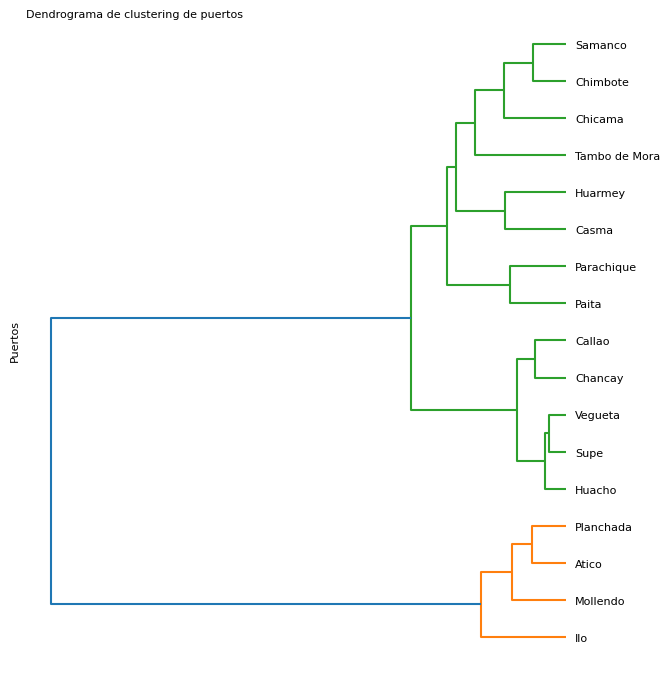

In [10]:


df_correlacion = significant_correlations_filtered.fillna(0)

fig = plt.figure(figsize=(6, 7))
ax = plt.axes([0.05, 0.05, 0.9, 0.9])
dendrogram = sch.dendrogram(
    sch.linkage(df_correlacion, method='ward'), 
    labels=df_correlacion.index, 
    leaf_rotation=0,
    orientation="left", 
    ax=ax
)
ax.set_title("Dendrograma de clustering de puertos", fontsize=8, loc='left')
ax.set_xlabel(" ", fontsize=8)
ax.set_ylabel("Puertos", fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([])


In [11]:
num_clusters = 5 
clusters = fcluster(sch.linkage(df_correlacion, method='ward'), num_clusters, criterion='maxclust')

df_clusters = pd.DataFrame({'Puerto': df_correlacion.index, 'Grupo': clusters})
df_clusters.sort_values(by='Grupo', inplace=True)
df_clusters


,Puerto,Grupo
16,Ilo,1
14,Planchada,1
13,Atico,1
15,Mollendo,1
11,Callao,2
10,Chancay,2
9,Huacho,2
8,Vegueta,2
7,Supe,2
1,Parachique,3


In [12]:
df_pivot.to_csv('../../data/imarpe/processed/df_produccion_combined_2002_2024_clean.csv')